#### Water-mass Methods Package
##### Minimum Transport Method (MTM) Tutorial by Taimoor Sohail

This tutorial script walks the user through the functionality of the MTM Code within the WM_Methods package

In [1]:
# Import the MTM function from the WM_Methods package
from WM_Methods import MTM
import numpy as np
import matplotlib.pyplot as plt

### Defining 'tracers' and 'volumes'

210.25 = 210.25000000000006


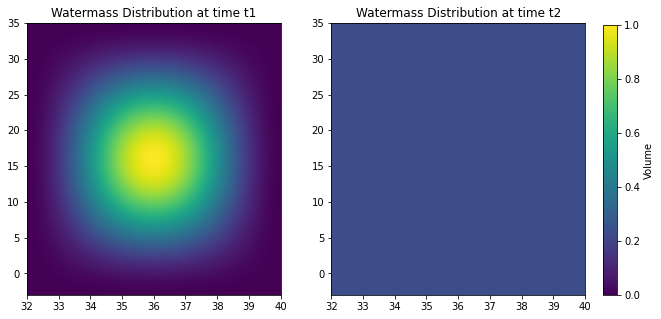

In [48]:
## Here, we create data that forms the basis of the TS bins that are fed into the optimiser
## In this tutorial, we choose the simplest example, a regular TS grid with a sinusoidal distribution weight that changes. 

# Number of watermasses

no_WMs = 20
## Note that the problem scales as no_WMs**4

## At time t1:
S1 = np.repeat(np.linspace(32,40,no_WMs)[:,np.newaxis], no_WMs,axis=-1)
T1 = np.repeat(np.linspace(-3,35,no_WMs)[np.newaxis,:], no_WMs,axis=0)
V1 = np.repeat((np.cos(np.linspace(np.pi*1.5,2.5*np.pi,no_WMs))**2)[:,np.newaxis], no_WMs,axis=-1)*\
    np.repeat((np.cos(np.linspace(np.pi*1.5,2.5*np.pi,no_WMs))**2)[np.newaxis,:], no_WMs,axis=0)

## At time t2:
## Note that the tracers X2 below do not have to stay the same - we only do this for the sake of this simple example
S2 = S1
T2 = T1
## We translate the volumes to some arbitrary location in TS space in our time t2
V2 = np.repeat((np.cos(np.linspace(np.pi*1.5,2.5*np.pi,no_WMs)-1)**2)[:,np.newaxis], no_WMs,axis=-1)*\
    np.repeat((np.cos(np.linspace(np.pi*1.5,2.5*np.pi,no_WMs)-1)**2)[np.newaxis,:], no_WMs,axis=0)

## Note that for the optimiser to work, the total initial V1 must be equal to the total final V2
# Thus, we scale the amplitude of V2 so it meets this criterion. 

V2 = V2*(V1.sum()/V2.sum())

### WE CAN ALSO TEST A PURE MIXING CASE (uncomment to try):
# V2 = np.zeros_like(V1)
# V2[(np.unravel_index(V1.argmax(), V1.shape))] = V1.sum()

### OR TEST A CASE WHERE V2 is homogeneous (uncomment to try):
# V2 = np.ones_like(V1)*(V1.sum()/V1.flatten().size)

## Check total volumes are the same 
print(V1.sum(), '=', V2.sum())

# In the real ocean, total change in volume is negligible, so V1.sum() will be approximately equal to V2.sum()
# If this is NOT the case, the optimiser will break 

## We plot the intial and final TS and volume distributions

fig, axs = plt.subplots(1,2, figsize=(10,5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 

axs[0].contourf(S1, T1, V1, 500,cmap=plt.cm.viridis, vmin=0, vmax=1)
axs[0].set_title('Watermass Distribution at time t1')

axs[1].contourf(S2, T2, V2, 500,cmap=plt.cm.viridis, vmin=0, vmax=1)
axs[1].set_title('Watermass Distribution at time t2')

cax = fig.add_axes([0.925, 0.125, 0.02, 0.75])

m = plt.cm.ScalarMappable(cmap='viridis')
m.set_clim(0, 1)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Volume') 

plt.show()



In [49]:
## Here, we create the tracers and volumes matrices, which will be fed into the MTM function

volumes = np.stack((V1.flatten(), V2.flatten()), axis=0) # Shape: [2 x N]

salinities = np.stack((S1.flatten(), S2.flatten()), axis=0)
temps = np.stack((T1.flatten(), T2.flatten()), axis=0)
## Add any further tracers at this line
generic_tracer = np.ones_like(temps)

tracers = np.stack((salinities, temps, generic_tracer),axis=1) # Shape: [2 x M x N], where M = 2 for just T and S, and M>2 for T,S+other tracers

### Defining 'constraints'

In [50]:
## The constraints matrix, which is between 0 and 1, (0 = disconnected; 1 = fully connected) defines the connectivity from one N watermass to another N watermass. 
# Here, we define all watermasses as fully connected, but this could be tweaked to be any number between 0 and 1. 

constraints = np.ones((V1.flatten().size,V2.flatten().size)) # Shape: [N x N] matrix

### Defining 'weights'

In [51]:
## The weights matrix defines any weighting (e.g. by surface area) to apply to the transport matrix
## Here, we define surface area for each water mass as 1 everywhere (i.e., it doesn't have a weight)

A1 = np.repeat((np.cos(np.linspace(np.pi*1.5,2.5*np.pi,no_WMs))**2)[:,np.newaxis], no_WMs,axis=-1)*\
    np.repeat((np.cos(np.linspace(np.pi*1.5,2.5*np.pi,no_WMs))**2)[np.newaxis,:], no_WMs,axis=0)
A2 = A1/A1

## A scaling to weight T and S changes equivalently:
alph = 1.7657*10**-4
bet = 7.5544*10**-4
ST_scale = (bet/alph)

## We create a weight matrix of ones
# Note that the code is very sensitive to the weights we input, and may break (TO BE DEVELOPED)
weights = np.stack((A2.flatten(),A2.flatten(), A2.flatten()), axis=0) # Shape: An [M x N] matrix

### Running the optimiser

In [52]:
## We run the optimiser to get the transports between water masses and the T,S mixed and T,S adjustment

result = MTM.optimise(tracers, volumes, constraints, weights)

g_ij = result['g_ij'] ## An [N x N] matrix of transports between WMs
Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM


                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) May 06 10:56:29 AM: Your problem has 810000 variables, 2 constraints, and 0 parameters.
(CVXPY) May 06 10:56:40 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 06 10:56:40 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 06 10:56:40 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 06 10:56:40 AM: Compiling problem (target solver=MOSEK).
(CVXPY) May 06 10:56:40 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

KeyboardInterrupt: 

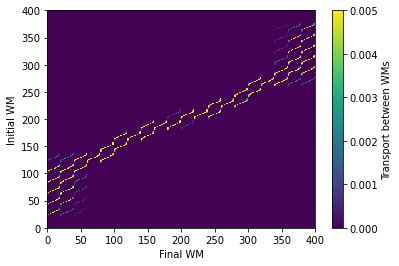

In [ ]:
## Plot the transport g_ij from WM initial to WM final

plt.pcolormesh(g_ij,vmin=0,vmax=0.005)
cbar = plt.colorbar()
cbar.set_label('Transport between WMs')
plt.xlabel('Final WM')
plt.ylabel('Initial WM')
plt.show()

In [ ]:
## Break down the Mixing and Adjustment matrices into their constituent tracers
dT_mixing = Mixing[1,:]
dS_mixing = Mixing[0,:]
dS_adj = Adjustment[0,:]
dT_adj = Adjustment[1,:]
dtracer_mixing = Mixing[2,:]
dtracer_adj = Adjustment[2,:]

### Plotting tracer mixing and adjustment

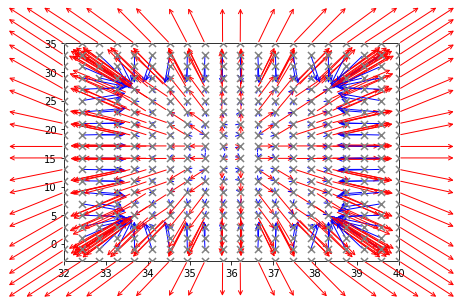

In [ ]:
## Vector Plot
# Here, we plot the vectors of mixing and adjustment from the initial watermass outwards

for i in range(V1.flatten().size):
        plt.scatter(tracers[0,0,i],tracers[0,1,i],\
                s=50,\
                marker = 'x', label = 't1', color='grey', zorder=100)
        if (dT_mixing[i]==-tracers[0,1,i]) | (dS_mixing[i] == -tracers[0,0,i]):
                plt.annotate('', xy=(tracers[0,0,i], tracers[0,1,i]), xytext=(tracers[0,0,i]+dS_adj[i], tracers[0,1,i]+dT_adj[i]),
        arrowprops=dict(arrowstyle="<-", color='red'))
        else:
                plt.annotate('', xy=(tracers[0,0,i], tracers[0,1,i]), xytext=(tracers[0,0,i]+dS_mixing[i], tracers[0,1,i]+dT_mixing[i]),
        arrowprops=dict(arrowstyle="<-", color='blue'))
                plt.annotate('', xy=(tracers[0,0,i]+dS_mixing[i], tracers[0,1,i]+dT_mixing[i]), \
                        xytext=(tracers[0,0,i]+dS_mixing[i]+dS_adj[i], tracers[0,1,i]+dT_mixing[i]+dT_adj[i]),
        arrowprops=dict(arrowstyle="<-", color='red'))

        plt.xlim(32,40)
        plt.ylim(-3,35)
plt.show()

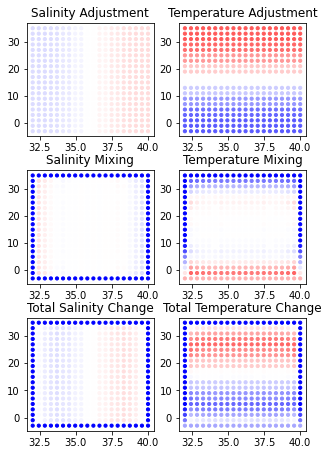

In [ ]:
## Visualise T and S mixing and adjustment as a colourmap on the initial watermass locations

fig, axs = plt.subplots(3,2, figsize=(5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=0.2)
axs = axs.ravel() 

minv, maxv = -10,10
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

axs[0].scatter(tracers[0,0,:], tracers[0,1,:], 10, color=cmap(norm(dS_adj[:])), zorder=100)
axs[0].set_title('Salinity Adjustment')

axs[1].scatter(tracers[0,0,:], tracers[0,1,:], 10, color=cmap(norm(dT_adj[:])), zorder=100)
axs[1].set_title('Temperature Adjustment')

axs[2].scatter(tracers[0,0,:], tracers[0,1,:], 10, color=cmap(norm(dS_mixing[:])), zorder=100)
axs[2].set_title('Salinity Mixing')

axs[3].scatter(tracers[0,0,:], tracers[0,1,:], 10, color=cmap(norm(dT_mixing[:])), zorder=100)
axs[3].set_title('Temperature Mixing')

axs[4].scatter(tracers[0,0,:], tracers[0,1,:], 10, color=cmap(norm(dS_mixing+dS_adj)), zorder=100)
axs[4].set_title('Total Salinity Change')

axs[5].scatter(tracers[0,0,:], tracers[0,1,:], 10, color=cmap(norm(dT_mixing+dT_adj)), zorder=100)
axs[5].set_title('Total Temperature Change')

plt.show()


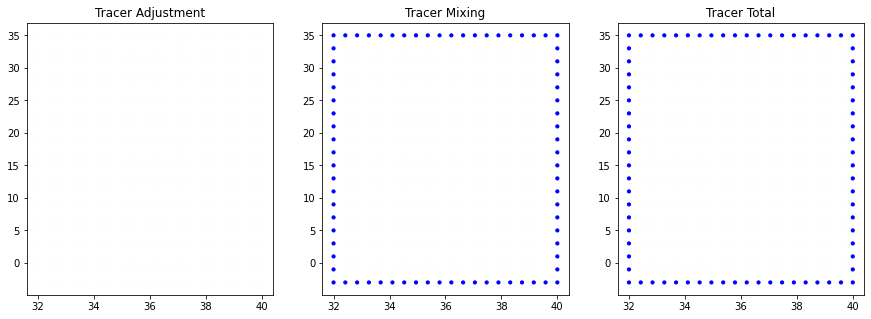

In [ ]:
## Visualise other tracer mixing and adjustment as a colourmap on the initial watermass locations

fig, axs = plt.subplots(1,3, figsize=(15,5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=0.2)
axs = axs.ravel() 


minv, maxv = -1,1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

axs[0].scatter(tracers[0,0,:], tracers[0,1,:], 10, color=cmap(norm(dtracer_adj[:])), zorder=100)
axs[0].set_title('Tracer Adjustment')

axs[1].scatter(tracers[0,0,:], tracers[0,1,:], 10, color=cmap(norm(dtracer_mixing[:])), zorder=100)
axs[1].set_title('Tracer Mixing')

axs[2].scatter(tracers[0,0,:], tracers[0,1,:], 10, color=cmap(norm(dtracer_mixing+dtracer_adj)), zorder=100)
axs[2].set_title('Tracer Total')

plt.show()